Imports

In [2]:
from dvclive.keras import DVCLiveCallback
from dvclive import Live
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from Segmentation_classification.utils.pconv_layer import PConv2D
from keras import layers, models, metrics
import cv2
import tensorflow as tf
import numpy as np
import os

os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# from keras.src import backend
# backend.update

Preprocessing

In [ ]:
cv2.setNumThreads(cv2.getNumThreads())


def extract(mode='train', dim=256):

    def gen_mask(polygon_coords):
        width, height = dim, dim
        # image = np.zeros((height, width), dtype=np.uint8)

        # Create a polygon mask
        polygon_mask = np.zeros((height, width), dtype=np.int32)
        for val, coord in enumerate(polygon_coords, 1):
            cv2.fillPoly(polygon_mask, [coord], val)
        return polygon_mask

    def preproc_polycoord(coord):  # convert and reshape float coordinates into int
        poly_coord_ = np.array(coord).reshape((-1, 2))  # reshape to (x, y)
        # convert coordinates range in (0-1) to image shape ie 256
        poly_coord_ *= dim
        poly_coord_ = np.round(poly_coord_).astype('int32')
        return poly_coord_

    X, Y1, Y2 = [], [], []
    count = 0
    for file in os.scandir(f'dataset/full_teeth/{mode}/labels'):
        with open(file.path, 'r') as dt:
            text = dt.read()

        if len(np_txt := text.split('\n')) == 2:
            cls_txt = [int(np.fromstring(i, sep=' ')[0]) for i in np_txt]
            np_txt = [np.fromstring(i, sep=' ')[1:] for i in np_txt]
        else:
            continue

        poly_coord = [preproc_polycoord(i) for i in np_txt]
        mask_img = gen_mask(poly_coord)
        # plt.imshow(mask_img , cmap='gray')
        # plt.show()

        img = cv2.imread(file.path.replace(
            'labels', 'images').split('.')[0]+'.jpeg')

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (dim, dim))
            X.append(img)
            Y1.append(mask_img)
            Y2.append(cls_txt)
            count += 1
        elif count > 10000:
            break
        else:
            continue

    Y2 = np.array(Y2)
    return np.array(X).astype(np.int32), np.array(Y1), Y2[:, 0], Y2[:, 1]


dim = 512
X_train, Y_train1, Y_train2, Y_train3 = extract(dim=dim)
# X_test, Y_test1, Y_test2, Y_test3 = extract(mode='test', dim=dim)
X_val, Y_val1, Y_val2, Y_val3 = extract(mode='validate', dim=dim)

Segmentation

In [4]:

base_model = EfficientNetV2B0(include_top=False, input_shape=(
    dim, dim, 3), include_preprocessing=False)
# Block 1
x = layers.UpSampling2D((2, 2))(base_model.output)
x = layers.Conv2DTranspose(
    1280, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    1280, (2, 2), padding='same', activation='relu')(x)
# Block 2
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(
    640, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    640, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    640, (2, 2), padding='same', activation='relu')(x)
# Block 3
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
# Block 4
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
# Block 5
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    512, (2, 2), padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(
    3, (1, 1), activation='softmax')(x)


# Create an instance of your custom model
model = models.Model(inputs=base_model.input, outputs=x)

2024-01-04 10:56:31.110347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0


24274472/24274472 [==============================] - 0s 0us/step


Training

In [5]:
dim = "768"
batch_size = 2
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', metrics.MeanIoU(3, sparse_y_pred=False)])
with Live(exp_name='Segmentation') as live:
    model.fit(X_train, Y_train1, batch_size=batch_size, epochs=50, verbose=1,
              validation_data=(
                  X_val, Y_val1), validation_batch_size=batch_size,
              callbacks=[PlotLossesKeras(), DVCLiveCallback(live=live)])

    model.save("Models/768segmentation.keras")
    live.log_artifact("Models/768segmentation.keras", type="model")
# loss, accuracy = model.evaluate(X_test, [Y_test1, Y_test2, Y_test3])
# error = 197871

Epoch 1/50


2024-01-04 10:56:57.650198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-04 10:56:58.851075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-04 10:57:09.697246: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efdd6f6db20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 10:57:09.697268: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-01-04 10:57:09.700890: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 10:57:09.753574: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

 60/689 [=>............................] - ETA: 4:29 - loss: 0.9299 - accuracy: 0.8844 - mean_io_u: 0.2969

In [ ]:
model.summary()
hist_df = pd.DataFrame(model.history.history)
hist_df.to_csv('768 segmentation.csv', index=False)
# model.save("seg_clss_iter1.keras")

In [4]:
import tensorflow as tf
import cv2


In [21]:

# model = tf.keras.models.load_model('Models/512segmentation.keras')
img = cv2.imread("dataset/full_teeth/test/images/00aab560-55e6-11ed-955d-83a4c059175a-checkinloweron-1675224740719.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_res = cv2.resize(img, (512, 512)).reshape((1, 512, 512, 3))
pred = model.predict(img_res)

1/1 [==============================] - 0s 24ms/step


In [ ]:
img.dtype

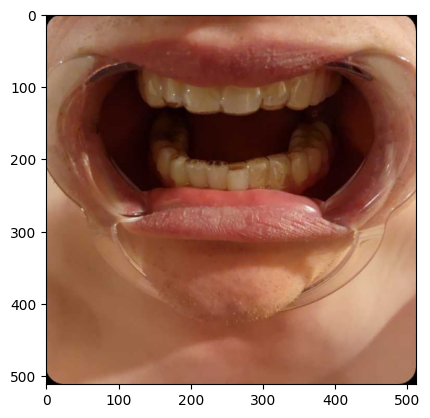

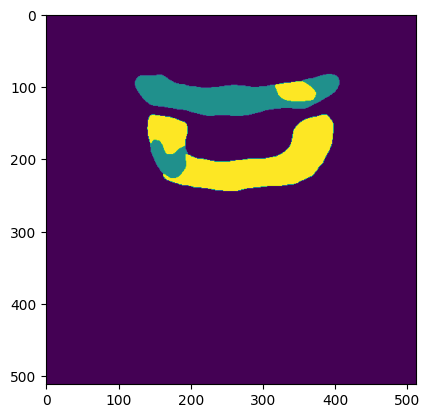

In [22]:
import matplotlib.pyplot as plt
import numpy as np

pred_img = np.argmax(pred, 3).reshape((512, 512))
plt.imshow(img_res.reshape((512, 512, 3)))
plt.show()
plt.imshow(pred_img.astype(np.uint))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
resized_img = np.copy(img_res)
contours, _ = cv2.findContours(pred_img.astype(
    np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Convert the contour to a list of polygon coordinates
polygon_coords = largest_contour.reshape(-1, 2)
# Optionally, you can round the coordinates to integer values
polygon_coords = np.round(polygon_coords).astype(int)
# Print or use the polygon coordinates
print("Polygon Coordinates:")
cv2.drawContours(resized_img, [polygon_coords], -1,
                 (255, 255, 255), thickness=cv2.FILLED)
plt.imshow(resized_img)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)